In [1]:
%pip install wandb
%pip install torch
%pip install simpletransformers

In [2]:
import wandb
import pandas as pd
from simpletransformers.t5 import T5Model
import yaml
import ast

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
%env WANDB_API_KEY=XXXXXXXXXX

env: WANDB_API_KEY=XXXXXXXXXX


In [4]:
# Google Colab Only:
import io
from google.colab import files
uploaded = files.upload()

Saving competitors_reddit.csv to competitors_reddit (1).csv
Saving singlatask_noupsampling_val.csv to singlatask_noupsampling_val (1).csv
Saving singletask_train.csv to singletask_train (1).csv


In [5]:
if uploaded:
    data = pd.read_csv(io.BytesIO(uploaded['competitors_reddit.csv']))
else:
    data = pd.read_csv('competitors_reddit.csv')

In [6]:
data.shape

(1974, 6)

## Preparing data for Title Recognition

In [7]:
data['reply_body_list']=data['reply_body'].apply(ast.literal_eval)

In [8]:
data['submission_selftext'] = data['submission_selftext'].fillna("")

In [9]:
data.head(5)

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body,reply_body_list
0,0,f96vya,New versions of A5 and A6 Agile firmwares are ...,NaN,"Dear Supernote users, new versions of A5 and A...","[""There was video of a multifunction button to...",[There was video of a multifunction button to ...
1,1,f9dsst,Feature request. Pressure sensitivity.,NaN,Thank you for the new firmware update. It adds...,['We are happy that you can enjoy this firmwar...,[We are happy that you can enjoy this firmware...
2,2,fp66n4,Quick Guide — Set Up and Connect to the Supern...,NaN,Set up and connect to the Supernote Cloud acco...,"[""What I would like to know is where can one b...",[What I would like to know is where can one bu...
3,3,fs454n,How to use handwriting to text function?,NaN,How do you achieve this? I've not been able to...,"['Currently you can try the ""Smart Writing"" fu...","[Currently you can try the ""Smart Writing"" fun..."
4,4,fs46fj,Email inbox issues,NaN,"I have set up my email, and can send emails. M...","[""Hi aubrit512,\n\nPlease try to update the sy...","[Hi aubrit512,\n\nPlease try to update the sys..."


In [10]:
# Combining text

In [11]:
def firstNComments(commentList, n=3):
    m = len(commentList)
    if m==0:
        return ""
    
    return " ".join(commentList[:min(n,m)])

In [12]:
data['all_text'] = data.apply(lambda x: " ".join([ \
     x['submission_selftext'], \
     firstNComments(x['reply_body_list'], n=4) \
    ] ),axis=1)

In [13]:
print("All data:", len(data))
print("Data with title not nan:",sum(data['submission_title'].notna()))
print("Data with title > 0 characters long",sum(data['submission_title'].apply(lambda x: len(x.strip()))>0))

print("So no need to remove data with no title")

All data: 1974
Data with title not nan: 1974
Data with title > 0 characters long 1974
So no need to remove data with no title


In [14]:
data.head(5)

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body,reply_body_list,all_text
0,0,f96vya,New versions of A5 and A6 Agile firmwares are ...,NaN,"Dear Supernote users, new versions of A5 and A...","[""There was video of a multifunction button to...",[There was video of a multifunction button to ...,"Dear Supernote users, new versions of A5 and A..."
1,1,f9dsst,Feature request. Pressure sensitivity.,NaN,Thank you for the new firmware update. It adds...,['We are happy that you can enjoy this firmwar...,[We are happy that you can enjoy this firmware...,Thank you for the new firmware update. It adds...
2,2,fp66n4,Quick Guide — Set Up and Connect to the Supern...,NaN,Set up and connect to the Supernote Cloud acco...,"[""What I would like to know is where can one b...",[What I would like to know is where can one bu...,Set up and connect to the Supernote Cloud acco...
3,3,fs454n,How to use handwriting to text function?,NaN,How do you achieve this? I've not been able to...,"['Currently you can try the ""Smart Writing"" fu...","[Currently you can try the ""Smart Writing"" fun...",How do you achieve this? I've not been able to...
4,4,fs46fj,Email inbox issues,NaN,"I have set up my email, and can send emails. M...","[""Hi aubrit512,\n\nPlease try to update the sy...","[Hi aubrit512,\n\nPlease try to update the sys...","I have set up my email, and can send emails. M..."


## Train Test Split

In [15]:
all_titles_df = data[['all_text','submission_title']] \
    .rename(columns={"all_text":"input_text","submission_title":"target_text"})

In [16]:
all_titles_df['prefix']='title prediction'

In [17]:
all_titles_df.head(5)

,input_text,target_text,prefix
0,"Dear Supernote users, new versions of A5 and A...",New versions of A5 and A6 Agile firmwares are ...,title prediction
1,Thank you for the new firmware update. It adds...,Feature request. Pressure sensitivity.,title prediction
2,Set up and connect to the Supernote Cloud acco...,Quick Guide — Set Up and Connect to the Supern...,title prediction
3,How do you achieve this? I've not been able to...,How to use handwriting to text function?,title prediction
4,"I have set up my email, and can send emails. M...",Email inbox issues,title prediction


In [18]:
all_titles_df.to_csv('all_titles_df.csv',index=False)

In [19]:
train_title_df,val_title_df=train_test_split(all_titles_df, test_size=0.1,random_state=42)

In [20]:
print("train size:",len(train_title_df))
print("test size:",len(val_title_df))

train size: 1776
test size: 198


## Loading Tag Data

In [21]:
train_tag_df = pd.read_csv('singletask_train.csv')
val_tag_df = pd.read_csv('singlatask_noupsampling_val.csv')

In [22]:
train_tag_df['prefix']='classification'
val_tag_df['prefix']='classification'

In [23]:
train_tag_df.head(5)

,input_text,target_text,prefix
0,Battery drain i’ve been using my ipadpro for n...,Question,classification
1,GoodNotes on iCloud I can not find my GoodNote...,Question,classification
2,Flash card shuffle? Is there a way to shuffle ...,Question,classification
3,First Attempt With GoodNotes! Any thought? Ni...,Review,classification
4,Which backup is the best for good notes - Drop...,Question,classification


## Combining DataSets

In [24]:
train_combined_df = pd.concat([train_title_df,train_tag_df])
val_combined_df = pd.concat([val_title_df,val_tag_df])

In [25]:
print("train:",train_combined_df.shape)
print("test:",val_combined_df.shape)

train: (2088, 3)
test: (247, 3)


## 3. Model Training

In [26]:
model_args = {
    "output_dir": './multitask-upsample', #specify output directory
    "max_seq_length": 400,
    "train_batch_size": 2,
    "eval_batch_size": 2,
    "num_train_epochs": 3,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "use_multiprocessing": False,
    "fp16": False,
    "save_steps": -1,
    "save_eval_checkpoints": False,
    "save_model_every_epoch": False,
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "wandb_project": "T5 - multi task",
    "wandb_kwargs": {"name": "T5_multi_gpu"}
}

In [27]:
model = T5Model("t5", "t5-small", args=model_args, use_cuda=True)
model.train_model(train_combined_df, eval_data=val_combined_df)

  0%|          | 0/2088 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Using Adafactor for T5


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

wandb: Currently logged in as: roivian (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 3:   0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Running Epoch 1 of 3:   0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Running Epoch 2 of 3:   0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


(3132,
 {'global_step': [1044, 2088, 3132],
  'eval_loss': [0.6143649383598278, 0.18557098988657666, 0.07119938928266376],
  'train_loss': [1.0500328540802002, 1.0726746320724487, 0.21594898402690887]})

In [29]:
y_true = val_tag_df["target_text"].tolist()

In [34]:
# Prepare the data for testing
to_predict = [
    prefix + ": " + str(input_text)
    for prefix, input_text in zip(val_tag_df["prefix"].tolist(), val_tag_df["input_text"].tolist())
]
#y_true = val_tag_df["target_text"].tolist()
tasks = val_tag_df["prefix"].tolist()

# Get the model predictions
y_pred = model.predict(to_predict)

Generating outputs:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/hooks.py:62: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7face8c05a70> on tensor will not be serial

Decoding outputs:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/hooks.py:62: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fab9a933dd0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/usr/local/lib/python3.7/dist-packages/torch/utils/hooks.py:62: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fab9a69edd0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/usr/local/lib/python3.7/dist-packages/torch/utils/hooks.py:62: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7fab9a6a3f80> on tensor will not be serialized.  If this is exp

## Evaluation

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

       Question       0.90      0.92      0.91        39
         Review       0.20      0.50      0.29         2
Stylus problems       0.00      0.00      0.00         2
      Templates       1.00      0.67      0.80         6

       accuracy                           0.84        49
      macro avg       0.53      0.52      0.50        49
   weighted avg       0.85      0.84      0.84        49



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
labels = train_tag_df['target_text'].unique()

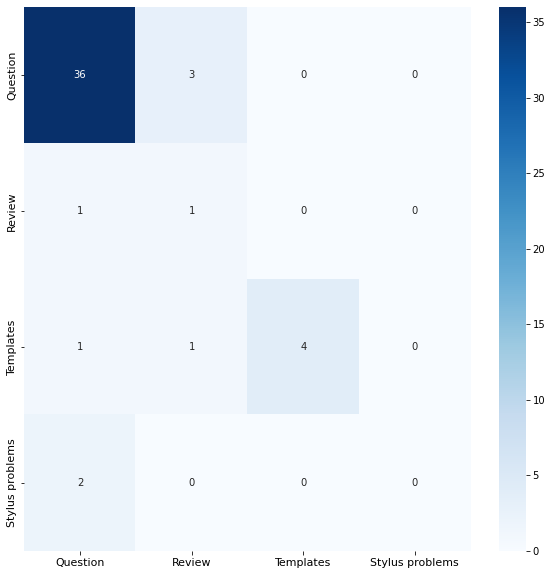

In [61]:
cm = confusion_matrix(y_true, y_pred, labels=labels)
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xticklabels(labels,fontsize=11)
ax.set_yticklabels(labels,fontsize=11);
#plt.xlabel('Predicted')
#plt.ylabel('True')

* Obtained F1 Score 0.91 comparatively with previously obtained 0.90 for class "Question"
* F1 score 0.8 comparatively with 0.57 for class "Templates"
* Worse F1 score for class "Review", and still 0 forecasts for class "Stylus problems"